# Variational Autoencoder

* [Moons](#moons)
* [MIMIC](#mimic)
* [MNIST](#mnist)
  * [Siamese metrics on MNIST](#siamese)

In [1]:
# for local testing
import sys
sys.path.append('../autopandas')

In [3]:
import autopandas as apd
from autopandas.generators import AE, VAE, SAE
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='moons'></a>
# Moons

In [4]:
gen = apd.generators.Artificial(method='moons')
data = gen.sample(10000, noise=0.05)
data.train_test_split(test_size=0.5, shuffle=False)

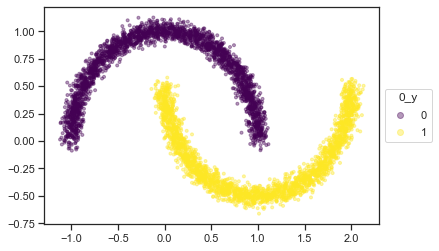

In [10]:
data('X_train').plot(c=data('y_train'))

In [37]:
vae = VAE(2, latent_dim=2, loss='mse') #nll
vae.fit(data('X_train'), epochs=5)

Epoch 1/5
5000/5000 [==============================] - 1s 142us/sample - loss: 1.3957
Epoch 2/5
5000/5000 [==============================] - 0s 36us/sample - loss: 1.0075
Epoch 3/5
5000/5000 [==============================] - 0s 35us/sample - loss: 0.7913
Epoch 4/5
5000/5000 [==============================] - 0s 35us/sample - loss: 0.6633
Epoch 5/5
5000/5000 [==============================] - 0s 35us/sample - loss: 0.5812


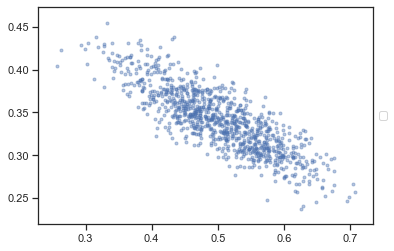

In [38]:
vae.sample(1000, loc=0, scale=1).plot()

In [39]:
# obviously not learning well...

<a id='mimic'></a>
# MIMIC 

In [4]:
# Load MIMIC dataset
train = apd.read_csv('data/mimic_train_sdv.csv') #[:200]
test = apd.read_csv('data/mimic_test_sdv.csv') #[:200]

# Define class
train.set_class('DIED')
test.set_class('DIED')

#data = apd.from_train_test(x_train, x_test)
input_dim = train.shape[1]

In [5]:
train.shape

(13463, 339)

### a. Visualization

In [6]:
train.head()

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,DIED,LOS,HR_MIN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0.736841,0.367033,0.178041,0.323594,0.178995,0.685247,0.695830,0.534141,0.007102,0.379733,...,0.566946,0.466166,0.454668,0.508533,0.043820,0.873301,0.439185,0.644301,0.927768,0.340453
1,0.325086,0.344490,0.104803,0.655811,0.783455,0.294163,0.398976,0.406052,0.018570,0.588893,...,0.998080,0.328330,0.248050,0.518272,0.475675,0.437482,0.300124,0.962873,0.200489,0.471393
2,0.365095,0.308756,0.431394,0.867922,0.765800,0.665502,0.799933,0.489344,0.006504,0.401370,...,0.560525,0.360634,0.359545,0.663067,0.062456,0.692662,0.137554,0.629658,0.914016,0.602066
3,0.076284,0.615019,0.186723,0.455209,0.347381,0.288593,0.731176,0.778186,0.010623,0.487919,...,0.513111,0.139621,0.480334,0.286370,0.414262,0.492274,0.865511,0.368510,0.817126,0.514404
4,0.180657,0.602065,0.864738,0.804294,0.297092,0.227642,0.029551,0.576505,0.012278,0.480707,...,0.451776,0.197078,0.419377,0.699087,0.332916,0.565916,0.208199,0.519025,0.823585,0.243542


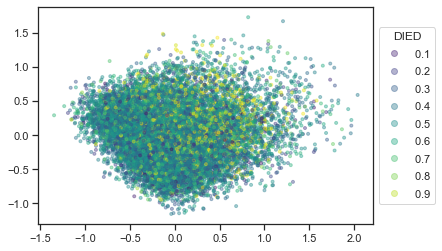

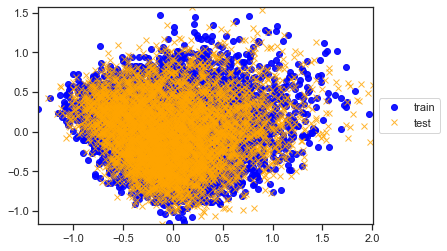

In [7]:
nb_to_plot = min(train.shape[0], 5000)

pca = train.pca(n_components=2).plot(c=train('y'))

pca_tr, pca_model = train.pca(n_components=2, return_param=True)
pca_tr = pca_tr[:nb_to_plot]
pca_te = test.pca(model=pca_model)[:nb_to_plot]
apd.plot(pca_tr, pca_te, names=['train', 'test'])

In [8]:
train.distance(test)

0

### b. Training

In [9]:
model = VAE(input_dim, latent_dim=8)
vae, encoder, decoder = model.autoencoder, model.encoder, model.decoder

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
batch_size=128
epochs=20

columns = train.columns
test_np = test.as_matrix()

model.fit(train,
          shuffle=True,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(test_np, test_np))

Train on 13463 samples, validate on 13463 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
13463/13463 [==============================] - 2s 114us/sample - loss: 89.0200 - val_loss: 88.6621
Epoch 2/20
13463/13463 [==============================] - 1s 39us/sample - loss: 88.2770 - val_loss: 88.1932
Epoch 3/20
13463/13463 [==============================] - 0s 36us/sample - loss: 87.8519 - val_loss: 87.9274
Epoch 4/20
13463/13463 [==============================] - 0s 36us/sample - loss: 87.5633 - val_loss: 87.7606
Epoch 5/20
13463/13463 [==============================] - 0s 36us/sample - loss: 87.3605 - val_loss: 87.4958
Epoch 6/20
13463/13463 [==============================] - 0s 35us/sample - loss: 87.1957 - val_loss: 87.4313
Epoch 7/20
13463/13463 [==============================] - 0s 36us/sample - loss: 87.0596 - val_loss: 87.1778
Epoch 8/20
13463/13463 [==============================] - 1s 37us/sample - loss: 86.9246 - val_loss: 87.0152
Epoch 9/20
13463/13463 [=====

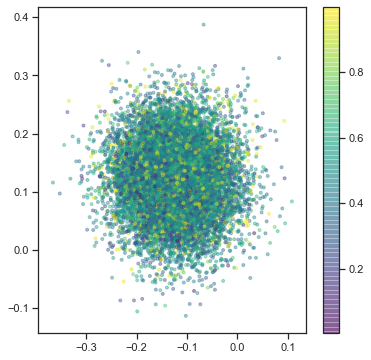

In [11]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(test_np, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=np.array(test('y').T).ravel(),
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

### c. Benchmark

In [12]:
# Generate samples
n = test.shape[0]
decoded = model.sample(n, loc=0, scale=6)

In [13]:
decoded.distance(test)

0

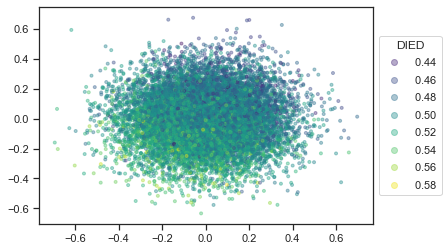

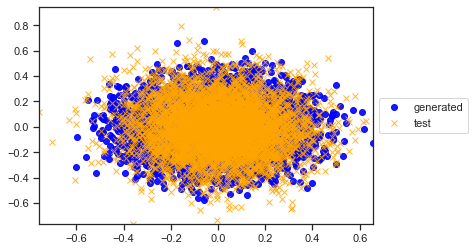

In [14]:
pca = decoded.pca(n_components=2).plot(c=decoded('y'))

pca_dec, pca_model = decoded.pca(n_components=2, return_param=True)
pca_dec = pca_dec[:nb_to_plot]
pca_te = test.pca(model=pca_model)[:nb_to_plot]
apd.plot(pca_dec, pca_te, names=['generated', 'test'])

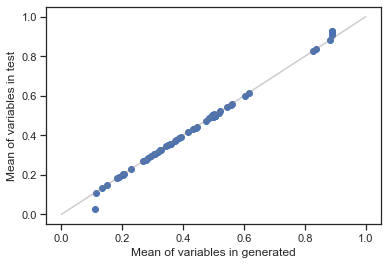

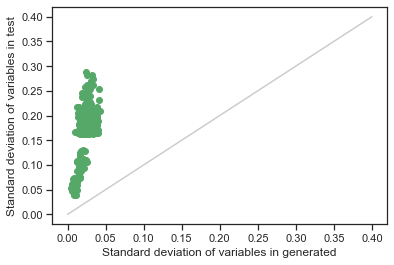

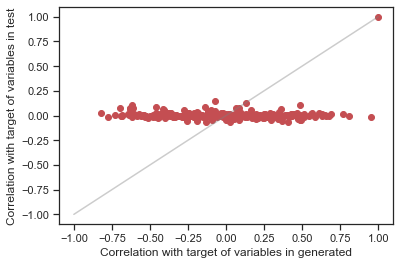

In [15]:
apd.compare_marginals(decoded, test, method='mean', name1='generated', name2='test')
apd.compare_marginals(decoded, test, method='std', name1='generated', name2='test')
apd.compare_marginals(decoded, test, method='corr', target='DIED', name1='generated', name2='test')

In [16]:
decoded.distance(test, method='discrepancy')

0.968432780391186

In [17]:
# utility
print(test.score())
print(decoded.score())

-0.0368998292284588
0.994795921607305


In [150]:
# save generated data
#x_decoded.to_csv('data/mimic_generated_sdv.csv')

In [14]:
# TODO NNAA between latent representation
# model.distance(decoded, train)
# model.distance(decoded, test)

<a id='mnist'></a>
# MNIST

In [4]:
from keras.datasets import mnist
from scipy.stats import norm

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
input_dim = 28*28

architecture = 'cnn'

if architecture == 'fully':
    # Fully connected
    x_train = x_train.reshape(-1, input_dim) / 255.
    x_test = x_test.reshape(-1, input_dim) / 255.
else:
    # CNN
    x_train = x_train.reshape(x_train.shape[0],28,28,1) / 255
    x_test = x_test.reshape(x_test.shape[0],28,28,1) / 255
    input_dim = (28, 28, 1)

Using TensorFlow backend.


In [5]:
def show(example, reshape=True):
    if isinstance(example, apd.AutoData):
        example = np.array(example)
    if reshape:
        example = example.reshape(28, 28)
    plt.imshow(example)

# VAE

In [6]:
model = AE(input_dim, layers=[16, 8], latent_dim=6, loss='binary_crossentropy', architecture=architecture, optimizer='adam') #layers=256 #layers=[32, 8] # decoder_layers=[56, 128]
vae, encoder, decoder = model.autoencoder, model.encoder, model.decoder

Instructions for updating:
Colocations handled automatically by placer.


../autopandas/autopandas/generators/autoencoder.py:116: UserWarning: strides argument is currently not implemented.
  warn('strides argument is currently not implemented.')


In [7]:
# show model
#from keras.utils import plot_model
#plot_model(model.autoencoder, show_shapes=True)
#model.encoder.summary()

In [40]:
batch_size=100
epochs=10

model.fit(x_train,
          shuffle=True,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 32s 527us/sample - loss: 21.8863 - val_loss: 16.7420
Epoch 2/10
60000/60000 [==============================] - 31s 509us/sample - loss: 16.1806 - val_loss: 15.6474
Epoch 3/10
60000/60000 [==============================] - 30s 499us/sample - loss: 15.5144 - val_loss: 15.2280
Epoch 4/10
60000/60000 [==============================] - 31s 514us/sample - loss: 15.2158 - val_loss: 15.0196
Epoch 5/10
60000/60000 [==============================] - 30s 508us/sample - loss: 15.0133 - val_loss: 14.8658
Epoch 6/10
60000/60000 [==============================] - 30s 500us/sample - loss: 14.8752 - val_loss: 14.7042
Epoch 7/10
60000/60000 [==============================] - 30s 500us/sample - loss: 14.7634 - val_loss: 14.6037
Epoch 8/10
60000/60000 [==============================] - 30s 501us/sample - loss: 14.6772 - val_loss: 14.5823
Epoch 9/10
60000/60000 [==============================] - 30s 

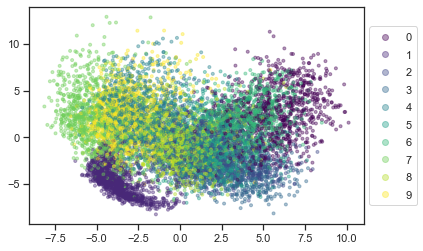

In [41]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
apd.AutoData(z_test).pca(n_components=2).plot(c=y_test)

../autopandas/autopandas/generators/autoencoder.py:188: UserWarning: Impossible to cast sampled data to autopandas.AutoData
  warn('Impossible to cast sampled data to autopandas.AutoData')


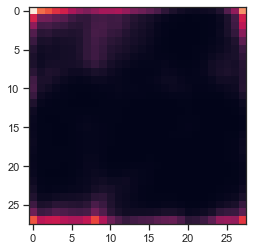

In [42]:
# invent
show(model.sample(1))

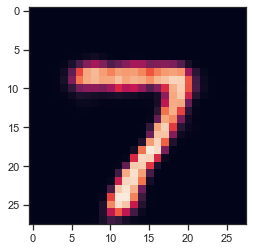

In [43]:
# reconstruct
show(model.autoencoder.predict(x_test[:1]))

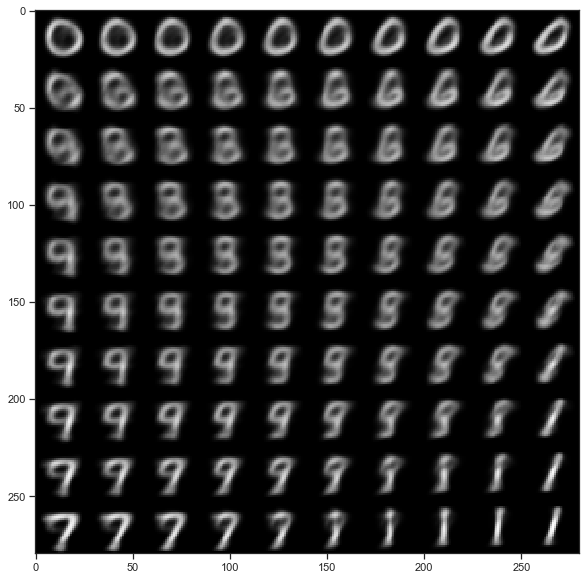

In [26]:
# display a 2D manifold of the digits

n = 10  # figure with 15x15 digits
digit_size = 28
# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2)) 
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)
plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()

In [27]:
x_decoded = np.array(model.sample(x_test.shape[0])) # generation

In [23]:
# PCA plot
#apd.AutoData(x_test).pca(n_components=2).plot(c=y_test)
#apd.AutoData(x_decoded).pca(n_components=2).plot()

Issue due to gaussian sampling?

<a id='siamese'></a>
# VAE siamese distance

![scheme](./siamese_autoencoder_scheme.png)

# NNAA between encoded True and Synthetic datasets

* Distance metric should make more sense in latent space than in original space
* Lighter to compute thanks to lower dimensionality
* Not that bad during initialization and then improved by training

In [28]:
# subsample for test
nb = 200
x_train = x_train[:nb]
x_test = x_test[:nb]
x_decoded = x_decoded[:nb]

In [29]:
print(model.distance(x_decoded, x_train, method='nnaa'))
print(model.distance(x_decoded, x_test, method='nnaa'))

0.5974999999999999
0.54


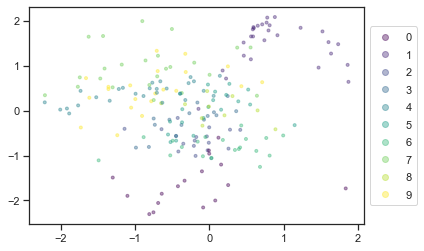

/usr/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


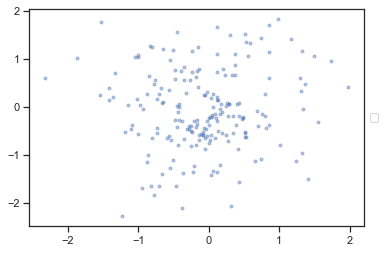

In [30]:
apd.AutoData(model.encoder.predict(x_test)).plot(c=y_test[:nb])
apd.AutoData(model.encoder.predict(x_decoded)).plot()

# Experiment 1: Compare Siamese NNAA to Classical NNAA

Compare metrics:
* NNAA
* Untrained Siamese NNAA
* Trained Siamese NNAA (during training)

Data from:
* Various generators: Copycat, GMM...
* Various VAE

In [ ]:
model.distance(x_train, x_test)

# Experiment 2: Siamese distance between points

Several times during training:
* Compute the siamese distance between an example and a translated version of it
* Compute the siamese distance between two different examples

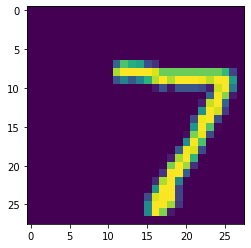

In [39]:
show(np.roll(x_test[0], 5, 0))

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 31s 513us/sample - loss: 28.8555 - val_loss: 20.8405
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 30s 495us/sample - loss: 19.9604 - val_loss: 19.0739
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 30s 495us/sample - loss: 18.9415 - val_loss: 18.4624
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 30s 497us/sample - loss: 18.5034 - val_loss: 18.1707
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 29s 492us/sample - loss: 18.2239 - val_loss: 17.9708
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 29s 489us/sample - loss: 18.0217 - val_loss: 17.8256
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 29s

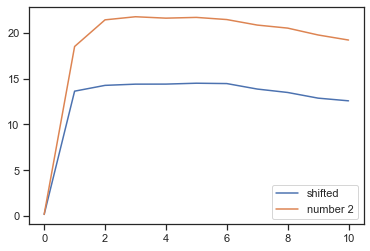

10.252306498679609
11.268815612372565


In [45]:
# only with architecture = CNN

epochs = 10

example = x_test[0] # image of a 7
example_shifted = np.roll(x_test[0], 5, 0) # translated
example_2 = x_test[1] # image of a 2

x = []
y1 = []
y2 = []
d = apd.metric.distance

for epoch in range(epochs):
    x.append(epoch)
    y1.append(model.siamese_distance(example, example_shifted))
    y2.append(model.siamese_distance(example, example_2))
    model.fit(x_train,
              shuffle=True,
              epochs=1,
              batch_size=120,
              validation_data=(x_test, x_test))

x.append(epochs)
y1.append(model.siamese_distance(example, example_shifted))
y2.append(model.siamese_distance(example, example_2))

plt.plot(x, y1, label='shifted')
plt.plot(x, y2, label='number 2')
plt.legend()
plt.show()

#print(d(example, example))
print(d(example, example_shifted))
print(d(example, example_2))

# SAE

"Fractal training"

Already exists -> stacked autoencoder

In [108]:
sae = SAE([input_dim, 256, 2], loss='mse', normalization=False)

In [109]:
sae.fit(x_train, epochs=[20, 40], batch_size=100, validation_data=(x_test, x_test))

Training model 1/2
Input shape: (60000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 58us/step - loss: 0.0191 - val_loss: 0.0070
Epoch 2/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.0059 - val_loss: 0.0051
Epoch 3/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.0042 - val_loss: 0.0047
Epoch 4/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 5/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 7/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/20
60000/60000 [==============================] - 3s 47us

In [110]:
data = x_train[:1]

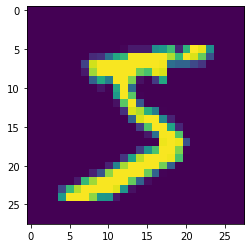

In [111]:
show(data)

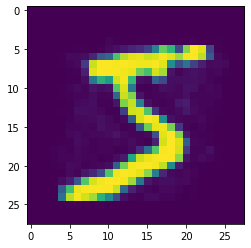

In [112]:
show(sae.models[0].autoencoder.predict(data))

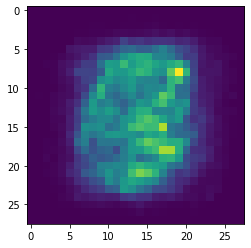

In [113]:
# TODO: looks like a bug
show(sae.autoencode(data))

In [90]:
x_train_enc = sae.models[0].encoder.predict(x_train)
x_test_enc = sae.models[0].encoder.predict(x_test)
#x_train_enc = sae.encode(x_train)
#x_test_enc = sae.encode(x_test)

In [91]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(x_train_enc, y_train)
clf.score(x_test_enc, y_test)

0.9025